## Imports and reading dataset


!pip install transformers torch

!pip install seqeval

!pip install git+https://www.github.com/keras-team/keras-contrib.git

!pip install googletrans==4.0.0-rc1
!pip install --upgrade googletrans==4.0.0-rc1

In [13]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter

from gensim.models import FastText

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from sklearn.metrics import accuracy_score, classification_report

import torch
from transformers import AutoTokenizer, AutoModel
from transformers import RobertaModel, RobertaTokenizer
from concurrent.futures import ProcessPoolExecutor


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Embedding, Flatten
from keras.utils import to_categorical
from keras.layers import Dropout

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\husse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\husse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
df = pd.read_csv("new_merged_df.csv")

# df = df.sort_values(by='emotion').reset_index(drop=True)

df

,text,emotion
0,da ana lma atkharrag,joy
1,baad el fetar hagelko,neutral
2,hahahahahha helw elkalam dah,happiness
3,kan 3ayz yroh yl3ab fe pyramids bayen,neutral
4,dah elly ana asdi aleih harfyan,neutral
...,...,...
2804,eh el araf da ana mt3sab,angry
2805,tab law omt w gbthalk..,neutral
2806,ana msh msda2 ana masdoom,surprise
2807,eh el mofg2at el 8areba de,surprise


neutral: Count = 867 -----------------> Percentage = 30.87%
joy: Count = 694 -----------------> Percentage = 24.71%
happiness: Count = 547 -----------------> Percentage = 19.47%
angry: Count = 394 -----------------> Percentage = 14.03%
sadness: Count = 155 -----------------> Percentage = 5.52%
surprise: Count = 91 -----------------> Percentage = 3.24%
fear: Count = 61 -----------------> Percentage = 2.17%
df shape : (2809, 2)


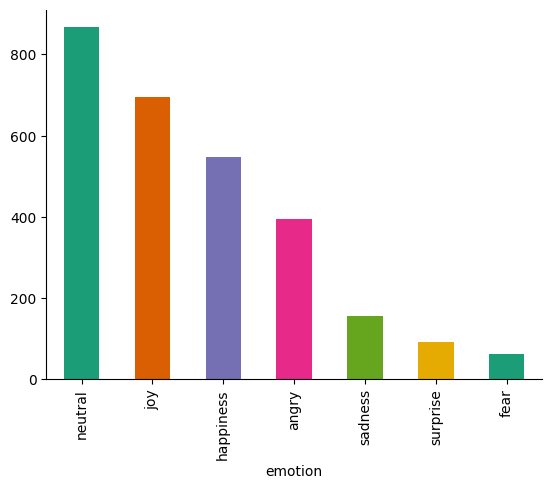

In [15]:
df.groupby('emotion').size().sort_values(ascending=False).plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

# Calculating and printing percentages in descending order
emotion_counts = df['emotion'].value_counts()
total_samples = len(df)

for emotion, count in emotion_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{emotion}: Count = {count} -----------------> Percentage = {percentage:.2f}%")
print("df shape :",f"{df.shape}")

#### test_df

- creating testing dataset to try it on both files (arabic and franco)

In [16]:
max_rows_per_emotion = 300  # Adjust this number as needed

selected_emotions = ['neutral', 'angry', 'sadness', 'surprise', 'happiness']
test_df = pd.DataFrame()

for emotion in selected_emotions:
    df_emotion = df[df['emotion'] == emotion].head(max_rows_per_emotion)
    test_df = pd.concat([test_df, df_emotion])

# Save the limited rows for each emotion to a new CSV file
test_df.to_csv('test_csv.csv', index=False)

print(f"Selected emotions saved with a maximum of {max_rows_per_emotion} rows for each emotion in 'test_csv.csv'")

Selected emotions saved with a maximum of 300 rows for each emotion in 'test_csv.csv'


In [17]:
test = pd.read_csv("test_csv.csv")
test

,text,emotion
0,baad el fetar hagelko,neutral
1,kan 3ayz yroh yl3ab fe pyramids bayen,neutral
2,dah elly ana asdi aleih harfyan,neutral
3,hwa kan 3ayz yehteref barra ala tol wla eh,neutral
4,da lesa badre,neutral
...,...,...
1141,bashofha bambeset 3alatoul,happiness
1142,yarab ayami kolaha tefdal sa3ida keda,happiness
1143,baheb awi el perfume dih,happiness
1144,mabda2eyan bas youmi ahsan mn youmko,happiness


In [18]:
test['emotion'].unique()

array(['neutral', 'angry', 'sadness', 'surprise', 'happiness'],
      dtype=object)

neutral: Count = 300 -----------------> Percentage = 26.18%
angry: Count = 300 -----------------> Percentage = 26.18%
happiness: Count = 300 -----------------> Percentage = 26.18%
sadness: Count = 155 -----------------> Percentage = 13.53%
surprise: Count = 91 -----------------> Percentage = 7.94%
df shape : (1146, 2)


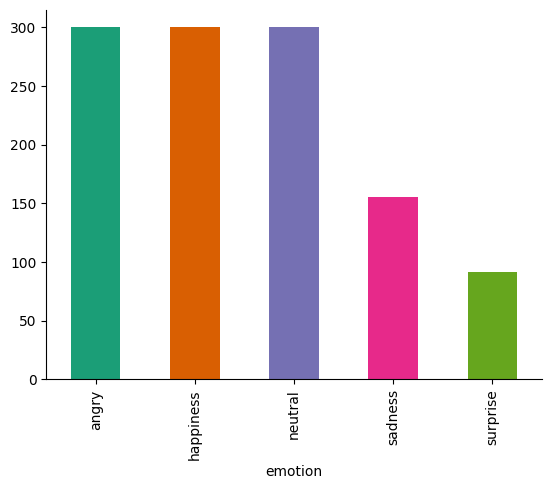

In [19]:
test.groupby('emotion').size().sort_values(ascending=False).plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

# Calculating and printing percentages in descending order
emotion_counts = test['emotion'].value_counts()
total_samples = len(test)

for emotion, count in emotion_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{emotion}: Count = {count} -----------------> Percentage = {percentage:.2f}%")
print("df shape :",f"{test.shape}")

## a) Step 1 : Preprocessing

<!-- + Remove URLs
+ Remove user mentions
+ Remove hashtags
+ Remove punctuation
+ Tokenize the text
+ Convert to lower case
+ Join the tokens back into a clean text -->

<!-- + Remove repeated letters -->




In [20]:
def clean_text(text):
    # Remove URLs https://www.example.com/
    text = re.sub(r'http\S+', '', text)

    # Remove user mentions @mohamed_samy
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)

    # Remove hashtags #free_palestine
    text = re.sub(r'#', '', text)

    # Remove punctuation period, comma, apostrophe, quotation, question, exclamation, brackets, braces, parenthesis, dash, hyphen, ellipsis, colon, semicolon
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove repeated letters
    # tokens = [re.sub(r'(.)\1+', r'\1', word) for word in tokens]

    # Convert to lower case
    tokens = [word.lower() for word in tokens]

    # Join the tokens back into a clean text
    clean_text = ' '.join(tokens)

    return clean_text

df['clean_text'] = df['text'].apply(clean_text)
df

,text,emotion,clean_text
0,da ana lma atkharrag,joy,da ana lma atkharrag
1,baad el fetar hagelko,neutral,baad el fetar hagelko
2,hahahahahha helw elkalam dah,happiness,hahahahahha helw elkalam dah
3,kan 3ayz yroh yl3ab fe pyramids bayen,neutral,kan 3ayz yroh yl3ab fe pyramids bayen
4,dah elly ana asdi aleih harfyan,neutral,dah elly ana asdi aleih harfyan
...,...,...,...
2804,eh el araf da ana mt3sab,angry,eh el araf da ana mt3sab
2805,tab law omt w gbthalk..,neutral,tab law omt w gbthalk
2806,ana msh msda2 ana masdoom,surprise,ana msh msda2 ana masdoom
2807,eh el mofg2at el 8areba de,surprise,eh el mofg2at el 8areba de


- Removing Duplicates again after cleaning

In [21]:
test_clean = clean_text("@Mo_Hussein eh elgamal da, alf mabrook!! #free_palestine https://www.example.com/")
test_clean

'eh elgamal da alf mabrook free_palestine'

### Translate clean_text to Arabic


https://github.com/ssut/py-googletrans/issues/257

In [22]:
from googletrans import Translator

def translate_to_arabic(text):
    translator = Translator()
    translation = translator.translate(text, dest='ar')
    return translation.text

In [23]:
df['arabic_text'] = df['clean_text'].apply(translate_to_arabic)
df

,text,emotion,clean_text,arabic_text
0,da ana lma atkharrag,joy,da ana lma atkharrag,ده أنا لما أتخرج
1,baad el fetar hagelko,neutral,baad el fetar hagelko,بعد الفطار هاجيلكو
2,hahahahahha helw elkalam dah,happiness,hahahahahha helw elkalam dah,هاهاهاهاها حلو الكلام ده
3,kan 3ayz yroh yl3ab fe pyramids bayen,neutral,kan 3ayz yroh yl3ab fe pyramids bayen,كان عايز يروح يلعب في بيراميدز بين
4,dah elly ana asdi aleih harfyan,neutral,dah elly ana asdi aleih harfyan,ده إلي أنا أسدي عليه حرفين
...,...,...,...,...
2804,eh el araf da ana mt3sab,angry,eh el araf da ana mt3sab,إيه إل عرف دى أنا متعصب
2805,tab law omt w gbthalk..,neutral,tab law omt w gbthalk,علامة التبويب قانون omt w gbthalk
2806,ana msh msda2 ana masdoom,surprise,ana msh msda2 ana masdoom,أنا مش مصدق أنا مصدوم
2807,eh el mofg2at el 8areba de,surprise,eh el mofg2at el 8areba de,إيه إل مفجأة إل ضربة د


In [24]:
test_statment = translate_to_arabic("eh elgamal da alf mabrook")
print(test_statment)

إيه الجمال دى ألف مبروك


## b) Step 2: The usage of Word Embedding
<!-- + AraBERT -->


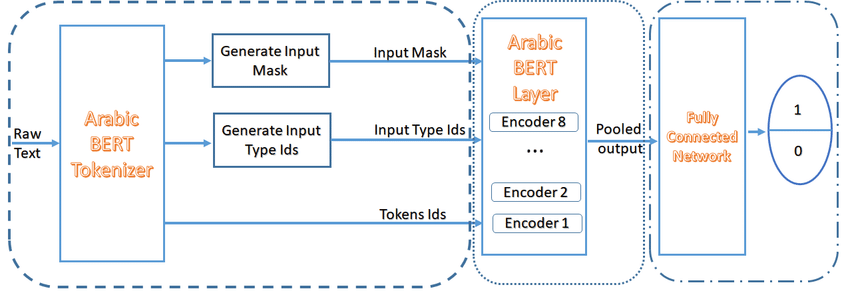

https://huggingface.co/asafaya/bert-base-arabic

- Load the pre-trained AraBERT tokenizer and model

In [25]:
# asafaya/bert-base-arabic
# Load AraBERT tokenizer and model
model_name = "aubmindlab/bert-base-arabertv02"
AraBERT_tokenizer = AutoTokenizer.from_pretrained(model_name)
AraBERT_model = AutoModel.from_pretrained(model_name)

In [26]:
def get_arabert_embedding(text):
    tokens = AraBERT_tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        model_output = AraBERT_model(**tokens)
    # Return the embeddings for the [CLS] token
    return model_output.last_hidden_state[:, 0, :].numpy()

In [27]:
# Apply the get_arabert_embedding function to the 'cleanedText' column
df['arabert_embedding'] = df['clean_text'].apply(get_arabert_embedding)

In [28]:
df

,text,emotion,clean_text,arabic_text,arabert_embedding
0,da ana lma atkharrag,joy,da ana lma atkharrag,ده أنا لما أتخرج,"[[0.5454751, 0.43432683, -0.07378585, -1.57207..."
1,baad el fetar hagelko,neutral,baad el fetar hagelko,بعد الفطار هاجيلكو,"[[1.1536006, 0.8544052, -0.20398256, -2.017871..."
2,hahahahahha helw elkalam dah,happiness,hahahahahha helw elkalam dah,هاهاهاهاها حلو الكلام ده,"[[0.94547844, 0.38081047, -0.40354136, -1.1815..."
3,kan 3ayz yroh yl3ab fe pyramids bayen,neutral,kan 3ayz yroh yl3ab fe pyramids bayen,كان عايز يروح يلعب في بيراميدز بين,"[[0.39184567, 0.15342335, -0.05676457, -1.4388..."
4,dah elly ana asdi aleih harfyan,neutral,dah elly ana asdi aleih harfyan,ده إلي أنا أسدي عليه حرفين,"[[0.5287757, 0.11002311, -0.23975497, -1.26346..."
...,...,...,...,...,...
2804,eh el araf da ana mt3sab,angry,eh el araf da ana mt3sab,إيه إل عرف دى أنا متعصب,"[[1.0628017, -0.35265028, -0.4830385, -1.78744..."
2805,tab law omt w gbthalk..,neutral,tab law omt w gbthalk,علامة التبويب قانون omt w gbthalk,"[[1.3995427, 0.48281622, -0.05384671, -0.84097..."
2806,ana msh msda2 ana masdoom,surprise,ana msh msda2 ana masdoom,أنا مش مصدق أنا مصدوم,"[[0.6048813, 1.2163547, -0.28346315, -2.001335..."
2807,eh el mofg2at el 8areba de,surprise,eh el mofg2at el 8areba de,إيه إل مفجأة إل ضربة د,"[[0.75176287, -0.99444634, 0.09746289, -1.0685..."


- Save the dataset after embedding 

In [29]:
# after_embedding_df = df.copy()
# after_embedding_df.to_csv('after_embedding_df.csv', index=False)

## c) Step 3: Models Development
<!-- + Split data into 80% train and 20% test
+ Bi-LSTM model devalopment
+ CNN model devalopment -->

<!-- https://en.wikipedia.org/wiki/Conditional_random_field#:~:text=Conditional%20random%20fields%20(CRFs)%20are,can%20take%20context%20into%20account. -->

In [30]:
X = df['arabert_embedding'].to_numpy()
y = df['emotion']

# Use LabelEncoder to encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Pad sequences to have the same length
X_train_pad = pad_sequences(X_train, padding='post', dtype='float32')
X_test_pad = pad_sequences(X_test, padding='post', dtype='float32')

In [31]:
print("X shape:", X.shape)
print("y_encoded:", y_encoded)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("X_train_pad shape:", X_train_pad.shape)
print("X_test_pad shape:", X_test_pad.shape)

X shape: (2809,)
y_encoded: [3 4 2 ... 6 6 4]
X_train shape: (1966,)
X_test shape: (843,)
y_train shape: (1966,)
y_test shape: (843,)
X_train_pad shape: (1966, 1, 768)
X_test_pad shape: (843, 1, 768)


- Bi-LSTM

In [32]:
# Bidirectional LSTM model
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_pad.shape[1], X_train_pad.shape[2])))
lstm_model.add(Bidirectional(LSTM(32)))
lstm_model.add(Dense(len(df['emotion'].unique()), activation='softmax'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_prob = lstm_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get class names
class_names = label_encoder.classes_

# Print class names in the classification report
report = classification_report(y_test, y_pred, target_names=class_names)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2%}")
print("Classification Report:\n", report)


Epoch 1/5


50/50 [==============================] - 7s 34ms/step - loss: 1.6986 - accuracy: 0.2952 - val_loss: 1.6356 - val_accuracy: 0.3020
Epoch 2/5
50/50 [==============================] - 0s 7ms/step - loss: 1.6377 - accuracy: 0.3206 - val_loss: 1.6112 - val_accuracy: 0.3350
Epoch 3/5
50/50 [==============================] - 0s 6ms/step - loss: 1.6156 - accuracy: 0.3391 - val_loss: 1.6177 - val_accuracy: 0.3325
Epoch 4/5
50/50 [==============================] - 0s 6ms/step - loss: 1.6008 - accuracy: 0.3378 - val_loss: 1.6354 - val_accuracy: 0.3122
Epoch 5/5
27/27 [==============================] - 1s 2ms/step
Accuracy: 35.47%
Classification Report:
               precision    recall  f1-score   support

       angry       0.24      0.41      0.30       112
        fear       0.00      0.00      0.00        17
   happiness       0.30      0.40      0.34       163
         joy       0.36      0.50      0.42       209
     neutral       0.58      0.31      0.40       268
     sadnes

In [33]:
# Load the Franco-Arabic test dataset
test_df = pd.read_csv('test_csv.csv')

# test_df = test_df[test_df['emotion'] != 'none']


# Apply the cleaning and translation to the test dataset
test_df['cleanedText'] = test_df['text'].apply(clean_text)

# trabslate the test dataset to arabic 
test_df['arabic_text'] = test_df['cleanedText'].apply(translate_to_arabic)

# Get AraBERT embeddings for the translated text
test_df['arabert_embedding'] = test_df['translatedText'].apply(get_arabert_embedding)

# Pad sequences
X_test_pad = pad_sequences(test_df['arabert_embedding'].to_numpy(), padding='post', dtype='float32')

# Test the model
y_pred_prob = lstm_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

# Inverse transform predictions to get emotion labels
predicted_emotions = label_encoder.inverse_transform(y_pred)

# Add predicted emotions to the test dataframe
test_df['predicted_emotion'] = predicted_emotions

# Display the test results
print(test_df[['text', 'predicted_emotion']])
print("Classification Report:")
print(classification_report(test_df['emotion'], test_df['predicted_emotion']))

36/36 [==============================] - 0s 2ms/step
                                            text predicted_emotion
0                          baad el fetar hagelko           neutral
1          kan 3ayz yroh yl3ab fe pyramids bayen           neutral
2                dah elly ana asdi aleih harfyan           neutral
3     hwa kan 3ayz yehteref barra ala tol wla eh             angry
4                                  da lesa badre           neutral
...                                          ...               ...
1141                  bashofha bambeset 3alatoul           neutral
1142       yarab ayami kolaha tefdal sa3ida keda               joy
1143                    baheb awi el perfume dih           neutral
1144        mabda2eyan bas youmi ahsan mn youmko           neutral
1145         sahya 3ala khabar khotoobet hadzyaa           neutral

[1146 rows x 2 columns]
Classification Report:
              precision    recall  f1-score   support

       angry       0.30      0.05      0

## Testing models
+ testing Bi-LSTM
+ testing CNN

In [35]:
def test_model_with_probabilities(model, label_encoder, text):
    
    print("Input is Franco-Arabic!")
    print("\n")

    print(f"Original User Input: {text}")
    print("\n")

    clean_Franco = clean_text(text)
    print(f"Cleaned User Input: {clean_Franco}")
    print("\n")

    translated_user_input = translate_to_arabic(clean_Franco)
    print(f"Translated User Input: {translated_user_input}")
    print("\n")


    text = translated_user_input


    print("----------------------------------------------------------------")

    embedding = get_arabert_embedding(text)
    # Pad the sequence
    padded_sequence = pad_sequences([embedding], padding='post', dtype='float32')
    # Make predictions
    prediction_prob = model.predict(padded_sequence)
    predicted_class = np.argmax(prediction_prob)
    # Convert predicted class back to the original label
    predicted_label = label_encoder.classes_[predicted_class]
    # Get class probabilities
    class_probabilities = {label: prob for label, prob in zip(label_encoder.classes_, prediction_prob[0])}

    return predicted_label, class_probabilities

In [36]:
def analyze_user_input(user_input_text):
    predicted_emotion, class_probabilities = test_model_with_probabilities(lstm_model, label_encoder, user_input_text)

    # Calculate total probability
    total_probability = sum(class_probabilities.values())

    # Print predicted emotion and percentage of each class in descending order
    print(f"Predicted Emotion: {predicted_emotion}")
    print("----------------------------------------------------------------")
    print("Class Probabilities:")
    sorted_probabilities = dict(sorted(class_probabilities.items(), key=lambda item: item[1], reverse=True))
    for emotion, probability in sorted_probabilities.items():
        percentage = (probability / total_probability) * 100
        print(f"{emotion}: {percentage:.2f}%")
    print("----------------------------------------------------------------")

    # Plotting the results
    fig, ax = plt.subplots()
    ax.bar(sorted_probabilities.keys(), sorted_probabilities.values())
    ax.set_ylabel('Probability')
    ax.set_title(f'Emotion Prediction (Descending Order)')
    ax.tick_params(axis='x', rotation=45)

    plt.show()

Input is Franco-Arabic!


Original User Input: @user_name el akl kan 7elw awii😍!! w kona mabsooten gdan😊, shof el link ---> https://mat3am.com


Cleaned User Input: el akl kan 7elw awii w kona mabsooten gdan shof el link


Translated User Input: إل أقل كان حلو أوي و كنا مبسوطين جدا شوف إل لينك


----------------------------------------------------------------
1/1 [==============================] - 0s 31ms/step
Predicted Emotion: neutral
----------------------------------------------------------------
Class Probabilities:
neutral: 34.15%
joy: 26.66%
happiness: 15.99%
angry: 13.17%
sadness: 5.22%
surprise: 2.97%
fear: 1.85%
----------------------------------------------------------------


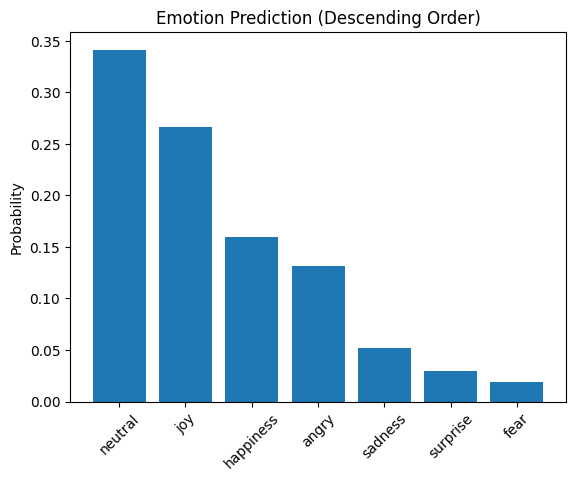

In [37]:
user_input_text = "@user_name el akl kan 7elw awii😍!! w kona mabsooten gdan😊, shof el link ---> https://mat3am.com"
analyze_user_input(user_input_text)